In [1]:
import gamepad as gp
from gamepad import GamepadHandler
from gettelemetry import TelemetryClient
import window as gwd
import wandb
import os
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
import torch.nn as nn
import mss
import cv2
import time
import numpy as np
import math

import pywinctl as gw
import vgamepad as vg
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import SAC
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback, CheckpointCallback
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.policies import BaseFeaturesExtractor
from stable_baselines3.common.callbacks import CallbackList

import torchvision.models as models
from torchvision import transforms

import logging
from stable_baselines3.common.monitor import Monitor

In [2]:
steps = 1000

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

wandb.login()
wandb.init(project="trackmania_sac")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: auschra3 (auschra3-massachusetts-institute-of-technology). Use `wandb login --relogin` to force relogin


In [3]:
class WindowCap():
    '''find the trackmania window and
    return gray normalised scaled pixel values'''

    def __init__(self, window_name):
        self.window_name = window_name
        self.window = gw.getWindowsWithTitle(window_name)
        if not self.window:
            raise Exception(f"Window with name '{window_name}' not found.")
        self.window = self.window[0]
        self.top = self.window.top
        self.left = self.window.left
        self.width = self.window.width
        self.height = self.window.height
        self.monitor = {"top": self.top, 
                        "left": self.left, 
                        "width": self.width, 
                        "height": self.height}
        
        self.sct = mss.mss()
        self.resize = 128

    def capture(self):
        img = np.array(self.sct.grab(self.monitor))
        # chop off top 1/3 of the screen
        img = img[int(self.height/3):]
        img = cv2.resize(img, (self.resize, self.resize))                       # resize
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)                              # convert BGR to RGB
        img = img / 255.0                                                       # normalise
        return img                                                              # (128, 128, 3)

    def __del__(self):
        self.sct.close()

In [4]:

# conv
class Conv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
            
        kernel_height = kernel_width = kernel_size
        sf = 1 / np.sqrt(in_channels * kernel_height * kernel_width)                # scaling factor
        self.weight = nn.Parameter(2 * sf * torch.rand(out_channels, 
                                                       in_channels, 
                                                       kernel_height, 
                                                       kernel_width) - sf)          # weight initialization
        self.bias = nn.Parameter(torch.zeros(out_channels))                         # bias initialization


    def forward(self, x):
        return F.conv2d(x, 
                        self.weight, 
                        self.bias, 
                        stride=self.stride, 
                        padding=self.padding)

    def display_image(self):
        return self.weight.detach().cpu().numpy()

    def extra_repr(self):
        keys = ["in_channels", "out_channels", "kernel_size", "stride", "padding"]
        return ", ".join([f"{key}={getattr(self, key)}" for key in keys])

class CustomCNN(BaseFeaturesExtractor):
    def __init__(self, observation_space: gym.spaces.Box, features_dim: int = 512):
        super().__init__(observation_space, features_dim)
        
        n_input_channels = observation_space.shape[0]
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # Define layers separately for visualization
        self.conv1 = nn.Conv2d(n_input_channels, 32, 
                              kernel_size=(8, 8),
                              stride=(4, 4),
                              padding=(0, 0))#.to(self.device)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        
        self.cnn = nn.Sequential(
            self.conv1,
            self.relu,
            self.flatten
        )#.to(self.device)

    def forward(self, observations):
        if isinstance(observations, np.ndarray):
            observations = torch.FloatTensor(observations)#.to(self.device)
        return self.cnn(observations)
    

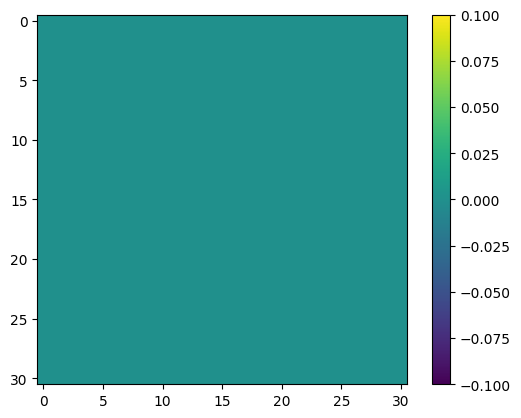

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
window = WindowCap("Trackmania")
obs = window.capture()
obs = np.expand_dims(obs, axis=0)
obs = np.transpose(obs, (0, 3, 1, 2))
obs = torch.FloatTensor(obs).to(device)

conv = CustomCNN(spaces.Box(low=0, high=1, shape=(3, 128, 128), dtype=np.float32)).to(device)
feature_maps = conv.conv1(obs)
feature_maps = conv.relu(feature_maps)
feature_maps_np = feature_maps.detach().cpu().numpy()

plt.imshow(feature_maps_np[0, 0, :, :])
plt.colorbar()
plt.show()


In [6]:

class TrackmaniaEnv(gym.Env):
    def __init__(self, window_name="Trackmania"):
        super(TrackmaniaEnv, self).__init__()
        self.window = WindowCap(window_name)                                # capture window
        self.gamepad = GamepadHandler()                                     # init gamepad
        self.client = TelemetryClient()                                     # init telemetry client
        self.telemetry = self.client.get_data()                             # get telemetry, unsure if this does anything

        if not self.gamepad:
            print("Failed to initialize gamepad")

        self.action_space = spaces.Box(
            low=np.array([-1.0, 0.0, 0.0]),
            high=np.array([1.0, 1.0, 1.0]),
            dtype=np.float32
        )                                                                   # action space                                 

        # obs space
        self.observation_space = spaces.Box(
            low=0,
            high=1,
            shape=(3, 128, 128),    
            dtype=np.float32        
        )                                                                   # observation space, (3, 128, 128)                             

        self.conv = CustomCNN(self.observation_space)

        self.id = gwd.get_window_id("Trackmania")
        self.focus = gwd.focus_window(self.id)                              # focus on window
        self.reward_range = (-np.inf, np.inf)                               # reward range
        self.metadata = {'render.modes': ['human']}                         # render mode
        self.terminated = False  
        self.truncated = False  
        self.reward = 0  
        self.prev_action = np.array([0, 0, 0])  
        self.prev_obs = np.zeros((1, 128, 128), dtype=np.float32)           # initiate variables
        self.steps = 0                                                      
        self.episode_reward = 0                                             
        self.episode_steps = 0
        self.checkpoint = 0
        self.episode_start_time = None
        self.step_start_time = None
        self.speed_buffer = []
        

    def reset(self, seed=None):
        self.gamepad.reset()
        time.sleep(1.5)                                                     # wait for lights to go green
        self.focus = gwd.focus_window(self.id)                              # unsure if necessary
        self.episode_steps = 0                                              # reset counters
        self.episode_reward = 0
        self.reward = 0
        self.episode_start_time = time.time()
        self.step_start_time = time.time()
        self.terminated = False
        self.prev_action = np.array([0, 0, 0])                              # dummy obs

        obs = window.capture()                                              # (128, 128, 3)
        obs = np.expand_dims(obs, axis=0)                                   # (1, 128, 128, 3)
        obs = np.transpose(obs, (0, 3, 1, 2))                               # (1, 3, 128, 128)
        obs = torch.FloatTensor(obs)#.to(device)                             # send to device
        
        self.speed_buffer = []                                              # reset speed buffer
        self.telemetry = self.client.get_data()                             # get telemetry
        self.prev_position = np.array([
            round(self.telemetry['position']['x'], 4), 
            round(self.telemetry['position']['z'], 4)])                     # [x, z]

        self.episode_start_time = time.time()                               # reset episode start time
        self.step_start_time = time.time()                                  # reset step start time

        if seed is not None:
            self.seed(seed)                                                 # set seed, dont know what this does

        return obs, {}

    def step(self, action):
        '''
        take a step in the environment
        '''
        self.steps += 1
        self.episode_steps += 1
        self.gamepad.send_action(action)                                    # send action to gamepad and update prev action
        self.prev_action = action
        self.telemetry = self.client.get_data()
        self.speed_buffer.append(self.telemetry['speed'])                   # append speed to buffer, remove first if full, check crash
        if len(self.speed_buffer) > 20:
            self.speed_buffer.pop(0)       
        self.step_time = time.time() - self.step_start_time                 # count step time
        self.step_start_time = time.time()
        self.reward = self.get_reward()                                     # get reward
        self.episode_reward += self.reward                                  # update episode reward              
        self.terminated = self._check_finished()                            # check finished race
        self.truncated = self._check_truncated()                            # check crash, must be after reward, because...
        self.prev_position = np.array([
            round(self.telemetry['position']['x'], 4), 
            round(self.telemetry['position']['z'], 4)])                     # [x, z]

        obs = window.capture()                                              # (128, 128, 3)
        obs = np.expand_dims(obs, axis=0)                                   # (1, 128, 128, 3)
        obs = np.transpose(obs, (0, 3, 1, 2))                               # (1, 3, 128, 128)
        obs = torch.FloatTensor(obs)#.to(device)                             # send to device


        if self.steps % 500 == 0:                                          # print log 
            print(f"step: {self.steps} / {steps}")

        info = {
            'episode': {'r': self.episode_reward, 
                        'l': self.episode_steps, 
                        't': self.step_time, 
                        's': self.steps},}                                  # log info

        return obs, self.reward, self.terminated, self.truncated, info

    def seed(self, seed=None):
        np.random.seed(seed)

    def _check_truncated(self):
        '''
        check if car has crashed into a wall or off the track
        '''
        if self.episode_steps > 200 and all(i < 2 for i in self.speed_buffer):
            self.reward -= 2
            truncated = True
        else:
            truncated = False

        return truncated
    
    def _check_finished(self):
        finished = self.telemetry['finished']
        if finished:
            self.reward += 100 / (time.time() - self.episode_start_time)
            self.gamepad.press_a()
            self.terminated = True
        return finished

    def get_reward(self):
        '''
        return distance of camera pixel from last step
        '''
        reward = 0

        jerk_penalty = round(float(self.telemetry['jerk']) , 5)                       # jerk penalty, crash
        speed_reward = round(float(self.telemetry['speed']) / 50, 5)                  # speed reward
        steer_penalty = round(abs(float(self.telemetry['steer'])), 5)                 # steer reward
        slip_penalty = round(abs(self.telemetry["fl_slip"] + self.telemetry["fr_slip"]) * 0.5) # slip penalty    
        gear_reward = self.telemetry["gear"] - 1 if self.telemetry["gear"] > 1 else 0  # gear reward
        
        if self.steps >= 1:
            current_position = np.array([
                round(self.telemetry['position']['x'], 4), 
                round(self.telemetry['position']['z'], 4)])                           # ensure there is a previous position
            
            distance_reward = round(np.linalg.norm(current_position - self.prev_position), 5)**2    
        else:
            distance_reward = 0
            
        reward = abs(distance_reward) + speed_reward - jerk_penalty - steer_penalty - slip_penalty + gear_reward
        #print(f"jerk: {jerk_penalty}, speed: {speed_reward}, steer: {steer_penalty}, slip: {slip_penalty}, gear: {gear_reward}, distance: {distance_reward}")
        return reward

    def make_env():
        def _init():
            env = TrackmaniaEnv()
            return env

        return _init

    def close(self):
        del self.window
        self.client.close()

In [7]:
class CustomWandbCallback(BaseCallback):
    def __init__(self, verbose=0):
        super().__init__(verbose)

    def _on_step(self) -> bool:
        # Log only available metrics
        wandb.log({
            'reward': self.locals['rewards'],
            'timesteps': self.num_timesteps
        })

        # Log episode info if available
        info = self.locals.get('infos', [{}])[0]
        if info:
            wandb.log({
                'speed': info.get('speed', 0),
                'checkpoint': info.get('checkpoint', 0),
                'lap': info.get('lap', 0),
                'episode_duration': info.get('episode_duration', 0)
            })
        return True

In [8]:
# Reduced steps for initial testing
steps = 5000

# Use the custom feature extractor in the policy kwargs
policy_kwargs = dict(
    features_extractor_class=CustomCNN,
    features_extractor_kwargs=dict(features_dim=30752),
    net_arch=[256, 256],
    activation_fn=torch.nn.ReLU
)

env = TrackmaniaEnv()
env.reset()
env = DummyVecEnv([lambda: env])

load = False

# load model
if load:
    model = SAC.load("models/trackmania_sac6")
    model.set_env(env)
else:
    # if not loading, new model
    model = SAC(
        'MlpPolicy',
        env,
        verbose=1,
        gradient_steps=1,
        ent_coef='auto',
        target_entropy='auto',
        gamma=0.99,
        tau=0.005,
        buffer_size=20_000,
        policy_kwargs=policy_kwargs,
        device=device
)

# train
model.learn(total_timesteps=steps, callback=CustomWandbCallback())
model.save("models/trackmania_sac8")

# cleanup
#env.close()

Gamepad initialized
Connected to localhost:9001
Using cuda device
step: 500 / 5000
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 152      |
|    ep_rew_mean     | 60.7     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 11       |
|    time_elapsed    | 70       |
|    total_timesteps | 847      |
| train/             |          |
|    actor_loss      | -8.89    |
|    critic_loss     | 0.0646   |
|    ent_coef        | 0.8      |
|    ent_coef_loss   | -1.13    |
|    learning_rate   | 0.0003   |
|    n_updates       | 746      |
---------------------------------
step: 1000 / 5000
step: 1500 / 5000
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 268      |
|    ep_rew_mean     | -64.2    |
| time/              |          |
|    episodes        | 8        |
|    fps             | 11       |
|    time_elapsed    | 164      |
|    total_timesteps | 1869    

Recreating feature extractor


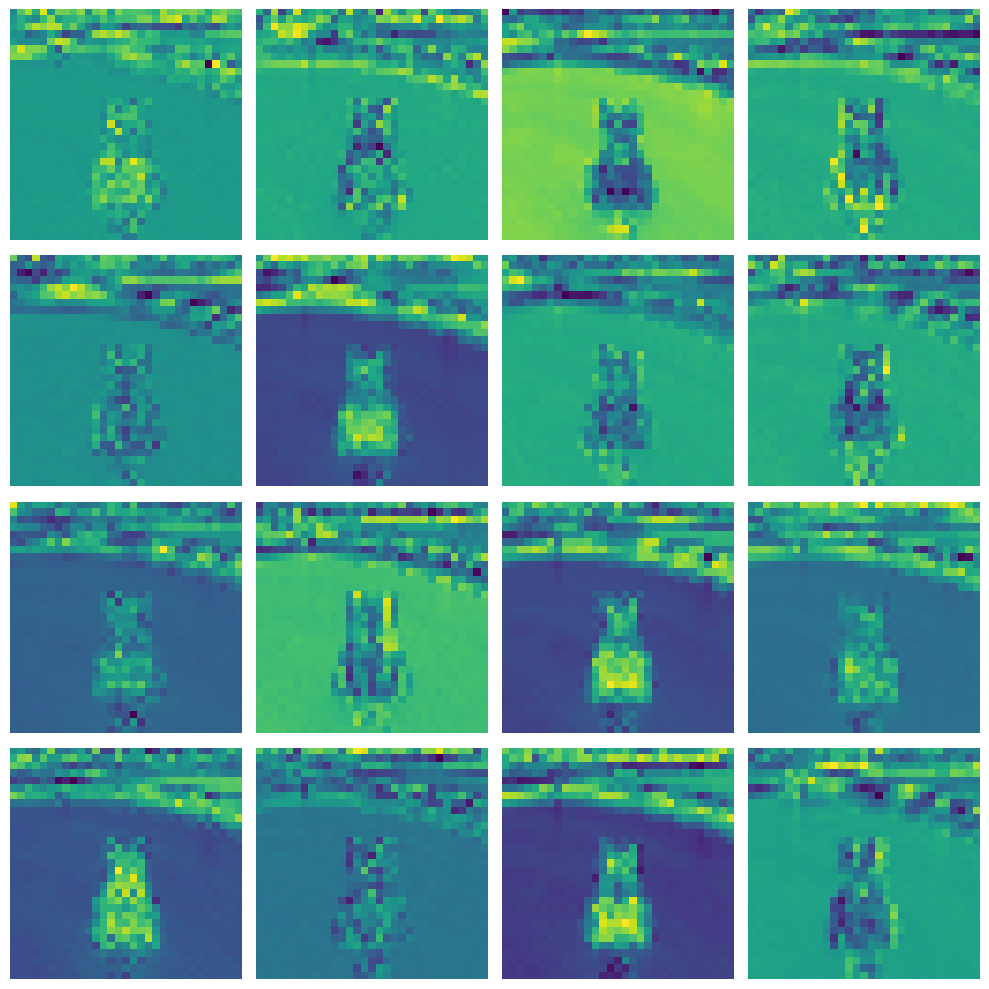

In [10]:
def visualize_feature_maps(env, model, num_maps=16):
    """
    Visualize feature maps from trained model
    """
    # Get observation
    obs = env.window.capture()
    obs = np.expand_dims(obs, axis=0)
    obs = np.transpose(obs, (0, 3, 1, 2))
    obs = torch.FloatTensor(obs)

    # Access the features extractor instance
    feature_extractor = model.policy.features_extractor

    # Recreate the feature extractor if it's None
    if feature_extractor is None:
        print("Recreating feature extractor")
        feature_extractor = CustomCNN(env.observation_space, features_dim=30752)
        
        # Copy the relevant parameters from the policy's state_dict
        policy_state_dict = model.policy.state_dict()
        feature_extractor_state_dict = {}
        for key, value in policy_state_dict.items():
            # Check for keys related to the feature extractor in actor, critic, and critic_target
            if "features_extractor" in key and ("actor" in key or "critic" in key):
                # Remove the prefixes
                new_key = key.replace("actor.", "").replace("critic.", "").replace("features_extractor.", "")
                feature_extractor_state_dict[new_key] = value

        feature_extractor.load_state_dict(feature_extractor_state_dict, strict=False)

    with torch.no_grad():
        # Get conv output using the instance
        features = feature_extractor.cnn[0](obs)  # Output of the first Conv2d layer
        features = features.cpu().numpy()

    # Plot feature maps in grid
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    for idx, ax in enumerate(axes.flat):
        if idx < num_maps:
            ax.imshow(features[0, idx, :, :], cmap='viridis')
            ax.axis('off')
    plt.tight_layout()
    plt.show()

model = SAC.load("models/trackmania_sac8")

# Call the function, providing your env
visualize_feature_maps(env.envs[0], model)
